## Handwritten Signature Verification using ResNet18

### Topic Information
This project involves developing a machine learning model to verify the authenticity of handwritten signatures using CNN architecture.

### Dataset Description
The project utilizes three benchmark datasets containing offline handwritten genuine and forged signatures:
- **CEDAR**: Contains English signatures.
- **BHSig260-Hindi**: Contains Hindi signatures.
- **BHSig260-Bengali**: Contains Bengali signatures.

### Steps in Data Preprocessing
- Renamed files in the CEDAR dataset for consistency.
- Collected data and labels from CEDAR, BHSig260-Hindi, and BHSig260-Bengali datasets.
- Created a unified dataset and split it into training, validation, and test sets.
- Applied image transformations (resizing and converting to tensor).

### Model Used: ResNet18
ResNet18 is chosen due to its:
- Ability to handle complex image recognition tasks.
- Efficient training with residual connections to prevent vanishing gradients.
- Pre-trained on large datasets, providing strong feature extraction capabilities.

### Results and Conclusion
The model achieved:
- **Validation Accuracy:** 95.02%
- **Validation Precision:** 94.51%
- **Validation Recall:** 94.38%
- **Validation F1-Score:** 94.44%

The confusion matrix showed the model's robust performance in distinguishing between genuine and forged signatures, indicating high accuracy and reliability in signature verification tasks.


#### Code comments are added to each and every code for more clarity.


In [2]:
#importing relevent libraries.
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns




# Function to rename files in the CEDAR folder
def rename_cedar_files(base_path):
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.startswith('forgeries') or file.startswith('original'):
                old_file_path = os.path.join(root, file)
                parts = file.split('_')
                if parts[0] == 'forgeries':
                    new_name = f'C-S-{parts[1]}-F-{parts[2].split(".")[0]}.png'
                elif parts[0] == 'original':
                    new_name = f'C-S-{parts[1]}-G-{parts[2].split(".")[0]}.png'
                new_file_path = os.path.join(root, new_name)
                os.rename(old_file_path, new_file_path)
                print(f'Renamed: {old_file_path} to {new_file_path}')

# Paths
base_cedar_path = '/kaggle/working/CEDAR'
signature_dataset_path = '/kaggle/input/signature-dataset'

# Rename files in the CEDAR folder
rename_cedar_files(base_cedar_path)



In [10]:
# Function to collect data and target labels from the dataset folders
def collect_data_and_labels():
    data = []
    target = []

    # Process CEDAR
    cedar_path = base_cedar_path
    for root, dirs, files in os.walk(cedar_path):
        for file in files:
            file_path = os.path.join(root, file)
            label = 1 if '-G-' in file else 0
            data.append(file_path)
            target.append(label)

    # Process Hindi
    hindi_path = os.path.join(signature_dataset_path, 'BHSig260-Hindi')
    for root, dirs, files in os.walk(hindi_path):
        for file in files:
            file_path = os.path.join(root, file)
            label = 1 if '-G-' in file else 0
            data.append(file_path)
            target.append(label)

    # Process Bengali
    bengali_path = os.path.join(signature_dataset_path, 'BHSig260-Bengali')
    for root, dirs, files in os.walk(bengali_path):
        for file in files:
            file_path = os.path.join(root, file)
            label = 1 if '-G-' in file else 0
            data.append(file_path)
            target.append(label)

    return data, target

# Collect data and labels
data, target = collect_data_and_labels()

# Create DataFrame
df = pd.DataFrame({"Data": data, "Target": target})

# Save DataFrame to CSV
output_csv = '/kaggle/working/dataset.csv'
df.to_csv(output_csv, index=False)


In [11]:
# Custom Dataset class
class SignatureDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = self.data_frame.iloc[idx, 0]
        image = Image.open(img_name).convert('RGB')
        label = int(self.data_frame.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label

In [12]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [13]:
# Create datasets
full_dataset = SignatureDataset(csv_file=output_csv, transform=transform)

In [14]:
# Split the dataset into training, validation, and test sets
train_idx, test_idx = train_test_split(list(range(len(full_dataset))), test_size=0.2, random_state=42)
train_idx, val_idx = train_test_split(train_idx, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

train_dataset = torch.utils.data.Subset(full_dataset, train_idx)
val_dataset = torch.utils.data.Subset(full_dataset, val_idx)
test_dataset = torch.utils.data.Subset(full_dataset, test_idx)

In [15]:
# Create dataloaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [16]:
# Example code for a model training loop (using a simple CNN as a placeholder)
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18

In [17]:
# Define the model (ResNet18)
model = resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # Adjust the final layer to match the number of classes

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 150MB/s] 


In [18]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [19]:
# Training loop
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')

Epoch 1/10, Loss: 0.36419987854675745
Epoch 2/10, Loss: 0.2442502452733037
Epoch 3/10, Loss: 0.18359114360599854
Epoch 4/10, Loss: 0.13729680961551377
Epoch 5/10, Loss: 0.09719120470744472
Epoch 6/10, Loss: 0.0804899535543574
Epoch 7/10, Loss: 0.07165060154781246
Epoch 8/10, Loss: 0.04678137572805811
Epoch 9/10, Loss: 0.045313734564459335
Epoch 10/10, Loss: 0.04101868257125149


In [29]:


# Evaluate on validation set
model.eval()
val_labels = []
val_preds = []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        val_labels.extend(labels.cpu().numpy())
        val_preds.extend(preds.cpu().numpy())
    
val_accuracy = accuracy_score(val_labels, val_preds)
val_precision = precision_score(val_labels, val_preds)
val_recall = recall_score(val_labels, val_preds)
val_f1 = f1_score(val_labels, val_preds)

print(f'Validation Accuracy: {val_accuracy}')
print(f'Validation Precision: {val_precision}')
print(f'Validation Recall: {val_recall}')
print(f'Validation F1-Score: {val_f1}')

Validation Accuracy: 0.9502398081534772
Validation Precision: 0.9450770261219023
Validation Recall: 0.9438127090301003
Validation F1-Score: 0.9444444444444444


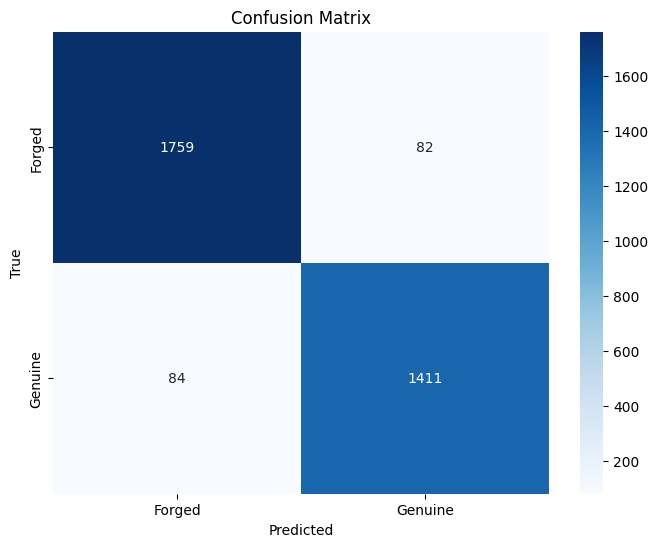

In [30]:
# Confusion Matrix
conf_matrix = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Forged', 'Genuine'], yticklabels=['Forged', 'Genuine'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()